# Loading the data and EDA

I'll start by loading the data into a pandas dataframe, looking at head() and describe(), checking for missing values, and making some initial plots of the prices of construction materials over time.

In [1]:
import pandas as pd
import numpy as np

mat_prices = pd.read_csv("../construction_material_prices_2008_2018.csv", index_col=0)
mat_prices.index = pd.to_datetime(mat_prices.index)
mat_prices.head()

price_steel  price_rebar  price_glass  price_concrete  \
2007-01-01          NaN          NaN          NaN             NaN   
2007-01-03          NaN          NaN          NaN             NaN   
2007-01-04          NaN          NaN          NaN             NaN   
2007-01-05          NaN          NaN          NaN             NaN   
2007-01-08          NaN          NaN          NaN             NaN   

            price_plywood  
2007-01-01            NaN  
2007-01-03            NaN  
2007-01-04            NaN  
2007-01-05            NaN  
2007-01-08            NaN

## Drop rows where all price values are null

I can see immediately in the head that there are some of rows (really dates) with no price informatiton for any materials. Actually the first 5 months of data are all empty... For now I'm going to drop all rows where every price column is null, arguably it might be better to infer some values for those rows but I'll start with the simplest approach.

In [2]:
mat_prices.dropna(how='all', subset=["price_steel", "price_rebar", "price_glass", "price_concrete", "price_plywood"], inplace=True)
mat_prices.head()

price_steel  price_rebar  price_glass  price_concrete  \
2007-06-01          NaN          NaN         22.0       29.033333   
2007-06-04          NaN          NaN         22.0       29.888889   
2007-06-05          NaN          NaN         22.0       29.200000   
2007-06-06          NaN          NaN         22.0       29.200000   
2007-06-07          NaN          NaN         22.0       28.363636   

            price_plywood  
2007-06-01       8.875000  
2007-06-04      10.833333  
2007-06-05      11.166667  
2007-06-06       9.750000  
2007-06-07      10.000000

In [3]:
mat_prices.describe()

price_steel  price_rebar  price_glass  price_concrete  price_plywood
count  2309.000000  1649.000000  1472.000000     1447.000000    2673.000000
mean     12.611319    18.306339    29.997962       26.000636      12.775067
std       6.038862     8.587938     6.524622        7.314764       3.931698
min       3.062500     3.000000    16.000000       10.416667       5.000000
25%       8.500000    12.071429    25.000000       20.559028      10.125000
50%      10.500000    16.500000    29.000000       25.043478      12.125000
75%      14.833333    22.500000    35.000000       30.000000      14.333333
max      41.000000    55.000000    48.000000       50.000000      34.000000

## Comments on the output from head() and describe()

There are few things we can take away from the head() and describe() outputs above:

1. Data wasn't collected on weekends! Visible in the jump from 2007-06-01 to 2007-06-04 in the output from head()
2. All of the price columns contain only numeric values, since they all appear in describe()
2. The mean gives me an average price, although this may not be very meaningful over the whole time range, I'll have to look at plots to see if there is an overall trend.
3. The std gives an approximate idea of what I should consider to be a signicant shift in the price for a given material, although again I need to see plots!

## Preliminary plotting

I'll make plots of the price of each material over time, let's see if there appears to be trends or seasonality according to the eyeball test.

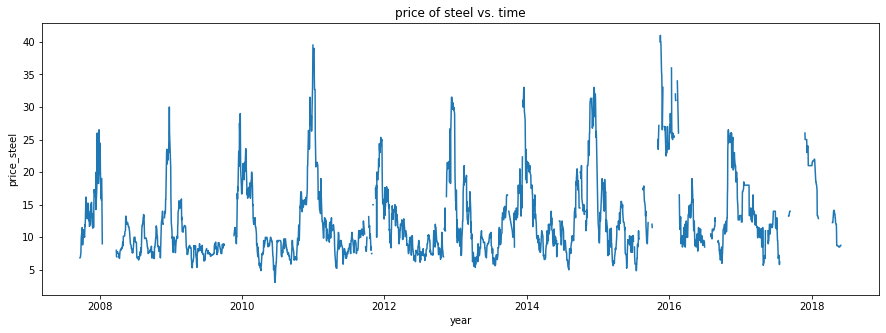

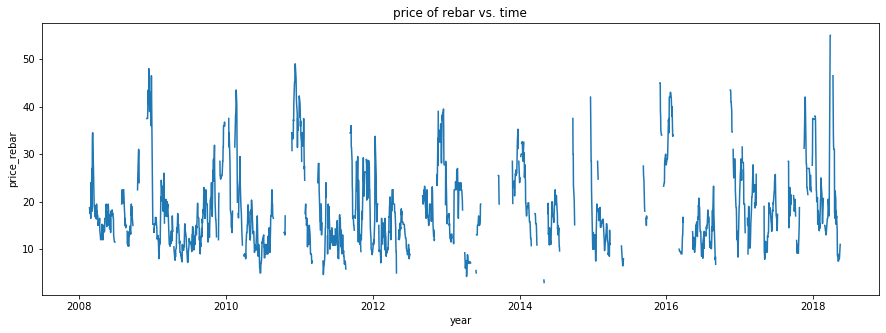

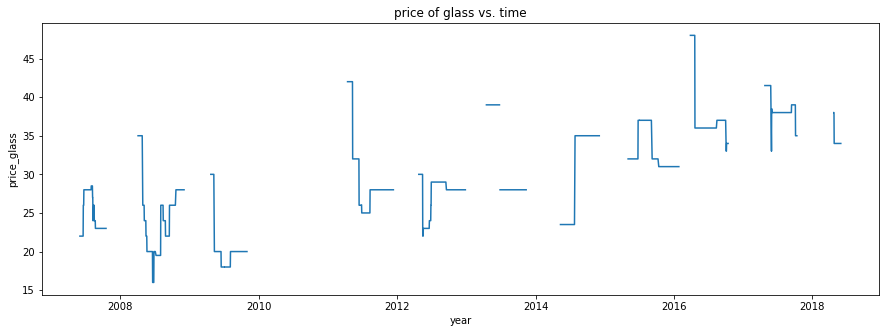

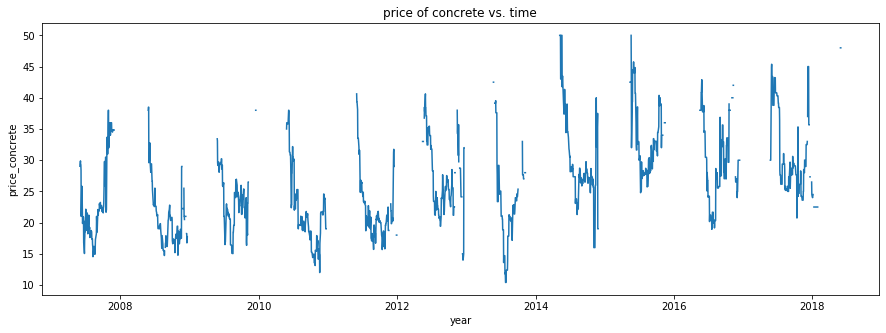

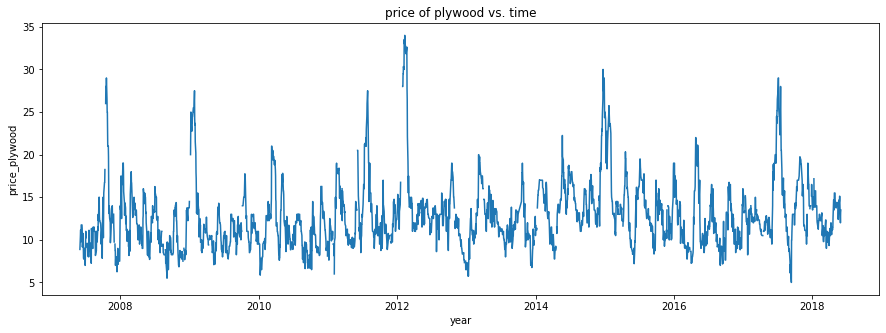

In [4]:
import matplotlib.pyplot as plt

for col in mat_prices.columns:
    plt.figure(figsize=(15,5))
    plt.plot(mat_prices[col])
    plt.xlabel("year")
    plt.ylabel(col)
    plt.title(col.replace("_", " of ") + " vs. time")
    plt.show()

## Initial plots discussion

General comments:

1. We have a number of missing data points in each column, price_glass is particularly bad.
2. There are what look like seasonal signals in the steel, rebar, and concrete prices. Glass is hard to tell due to missing data. Plywood I'm also not sure.
3. The price of glass seems to have an upwards trend and may not be stationary. The rest look stationary by eye but I'll test for it explicitly.

## Dealing with the missing data

I will start with the simple and definitely not ideal approach of just dropping the missing rows. This might cause trouble later on when trying to assess the seasonality, I'm not sure. I would definitely like to circle back and try imputing the missing values, time permitting.

Let's plot each column again with dropna() to see if there are major discontinuties visible.

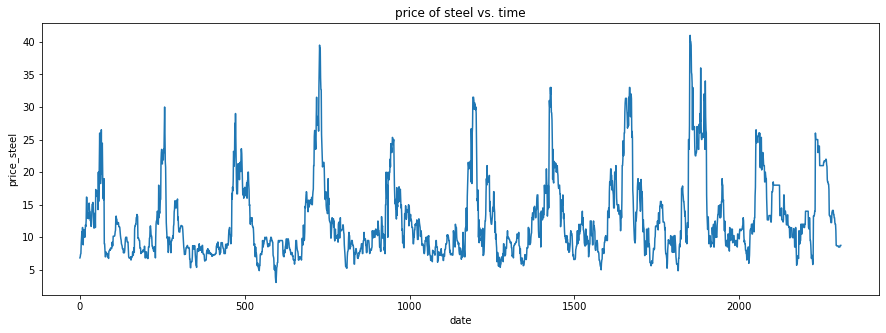

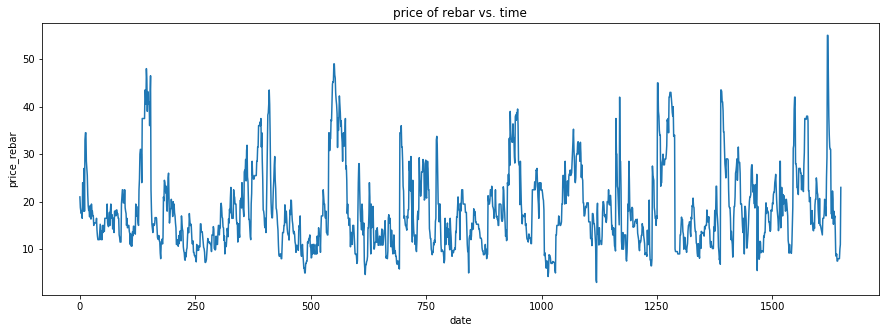

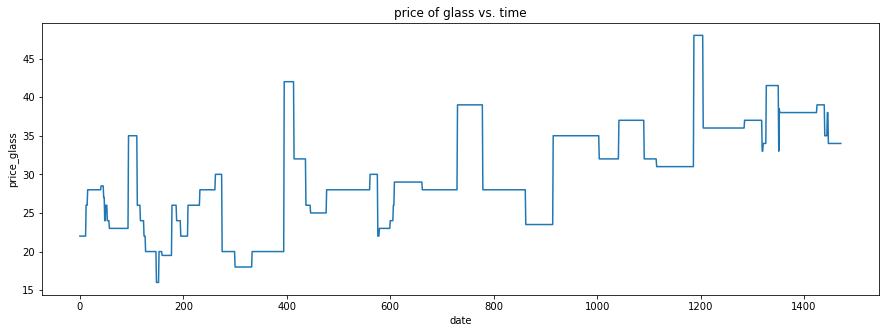

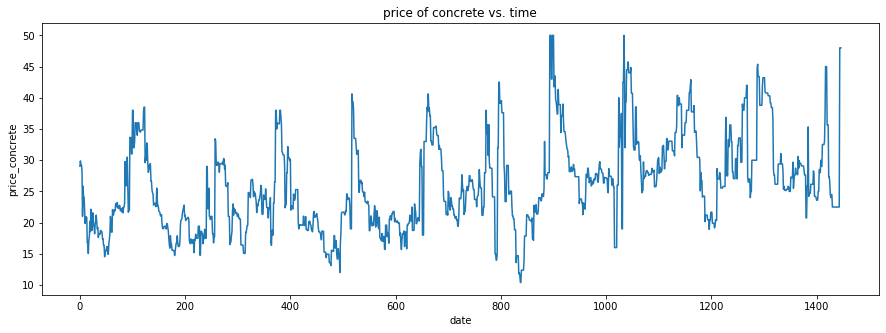

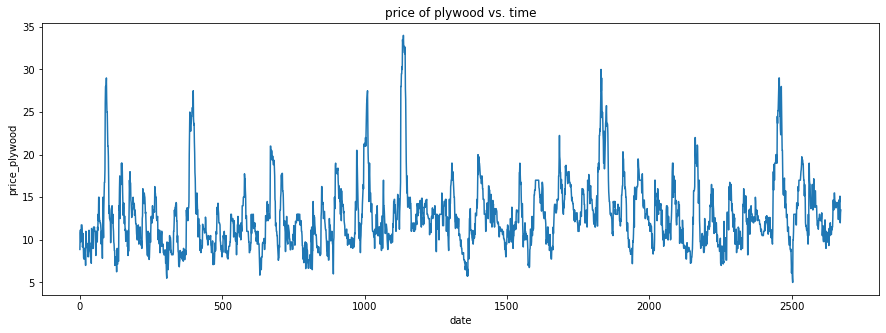

In [5]:
for col in mat_prices.columns:
    plt.figure(figsize=(15,5))

    plt.xlabel("date")
    plt.ylabel(col)
    plt.title(col.replace("_", " of ") + " vs. time")
    plt.show()

## Using pandas time interpolation to fill missing data

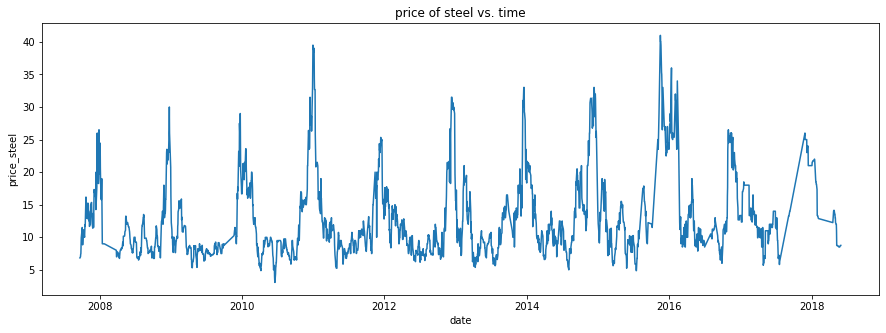

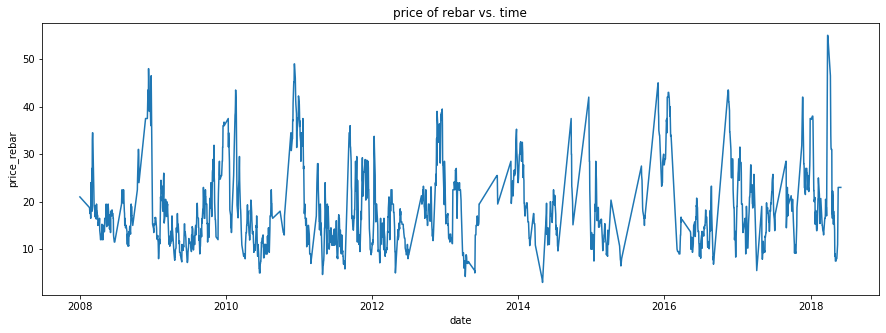

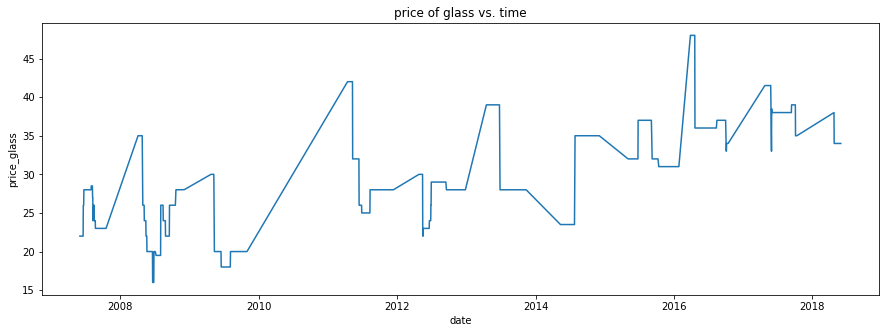

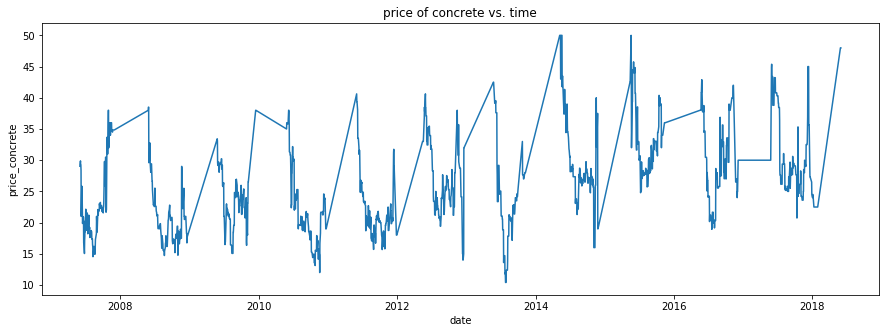

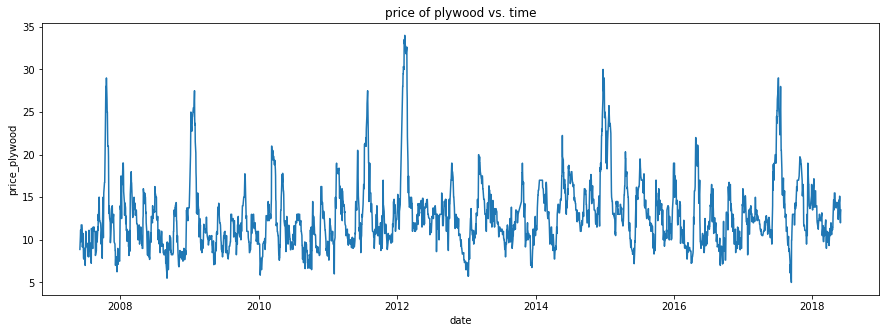

In [6]:
for col in mat_prices.columns:
    plt.figure(figsize=(15,5))
    interp_time = mat_prices[col].interpolate(method='time')
    plt.plot(interp_time)
    plt.xlabel("date")
    plt.ylabel(col)
    plt.title(col.replace("_", " of ") + " vs. time")
    plt.show()

### Imputing the missing data

The time interpolation method from pandas has introduced discontinuities in the slope, so I'll try imputing the missing data as I expect the interpolation will not produce trustworthy predictions.

After imputing, I will resample the data using the monthly mean. The main reason for this is that the daily data is quite noisy and I don't expect that level of granularity is necessary if in order to make 6 month price predictions. Another factor is that training on the daily data will be much slower. It might be worth also resampling with the weekly mean and training on that to see if it improves accuracy, but I will leave that for the future.

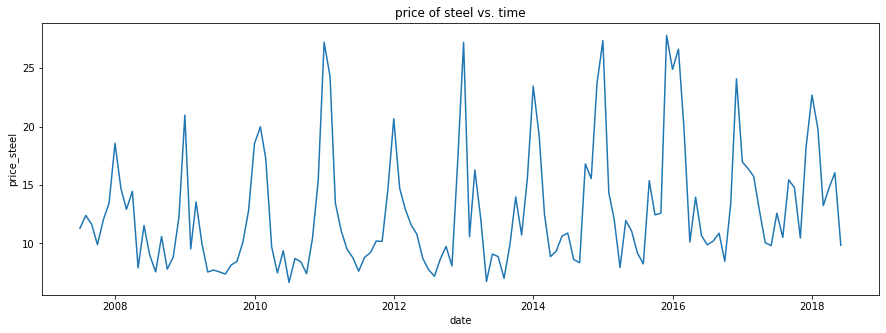

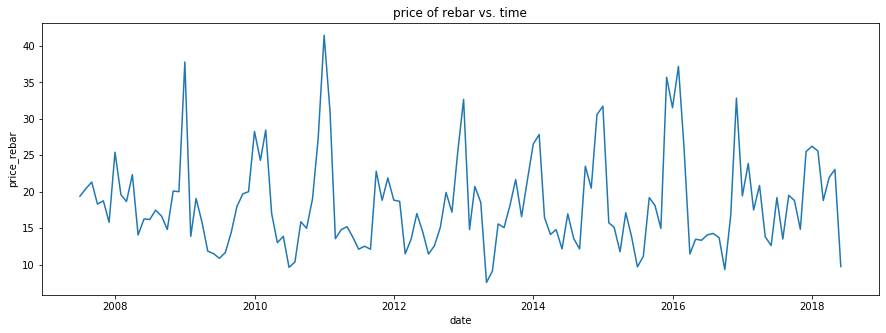

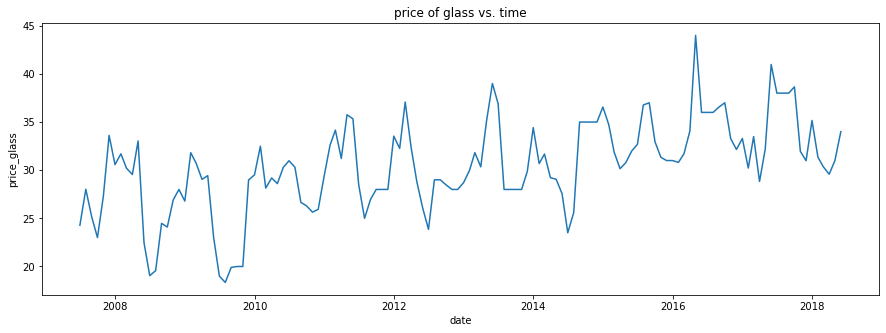

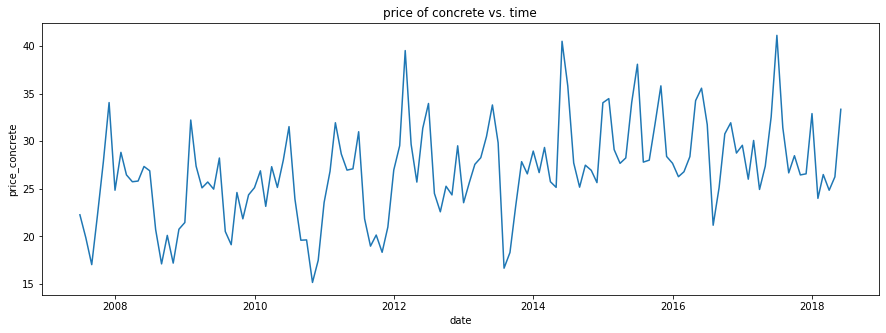

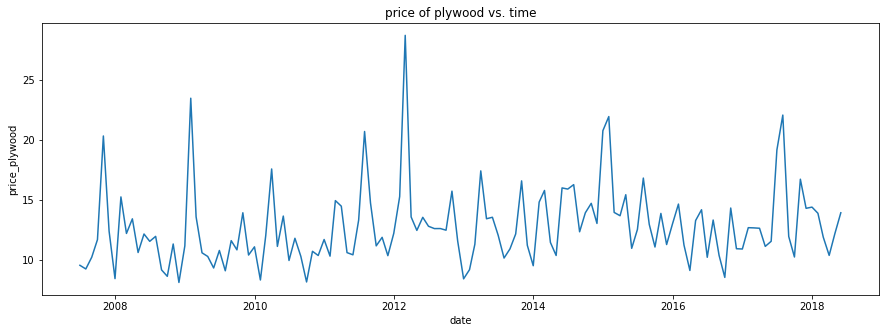

In [38]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imputer = IterativeImputer(max_iter=100)
mat_prices_imp = pd.DataFrame(imputer.fit_transform(mat_prices),
                              columns=mat_prices.columns, index=pd.to_datetime(mat_prices.index)).resample('M').mean()

for col in mat_prices_imp.columns:
    plt.figure(figsize=(15,5))
    plt.plot(mat_prices_imp[col])
    plt.xlabel("date")
    plt.ylabel(col)
    plt.title(col.replace("_", " of ") + " vs. time")
    plt.show()

# Preparing for model building

This data seems well suited to a seasonal ARIMA model. If I have time later I'll try an LSTM neural net as well and compare performance in a training/testing set.

To model (forecast) the data with seasonal ARIMA I'll have to determine a few things:

1. Is the data stationary?
2. Does the data need to be differenced?
3. What order should be assigned to the auto regressive (p) and moving average (q) terms in the ARIMA model?

## Test if the data is stationary

I'll use the augmented Dickey-Fuller test to determine if the prices are stationary (i.e. is there a trend in the mean price). The null hypothesis of the ADF test is non-stationarity, so if the p-values printed below are less than 0.05, I'll consider the data stationary (to 95% confidence level).

In [39]:
from statsmodels.tsa.stattools import adfuller

for col in mat_prices_imp.columns:
    print("Testing {}".format(col))
    print("Dickey–Fuller test: p=%f" % adfuller(mat_prices_imp[col])[1])
    print('Dickey-Fuller test ADF Statistic: %f' % adfuller(mat_prices_imp[col])[0])
    print()

Testing price_steel
Dickey–Fuller test: p=0.743822
Dickey-Fuller test ADF Statistic: -1.025576

Testing price_rebar
Dickey–Fuller test: p=0.000000
Dickey-Fuller test ADF Statistic: -8.306794

Testing price_glass
Dickey–Fuller test: p=0.000254
Dickey-Fuller test ADF Statistic: -4.438236

Testing price_concrete
Dickey–Fuller test: p=0.779026
Dickey-Fuller test ADF Statistic: -0.926779

Testing price_plywood
Dickey–Fuller test: p=0.000000
Dickey-Fuller test ADF Statistic: -8.469510



The price of steel and concrete are not stationary according to the ADF test. There also appears to be a yearly season trend, so I'm going to see if season differencing fixes the stationarity.

Dickey–Fuller test: p=0.000026
Dickey-Fuller test ADF Statistic: -4.969380


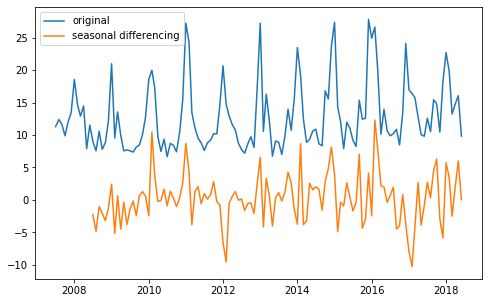

In [42]:
print("Dickey–Fuller test: p=%f" % adfuller(mat_prices_imp["price_steel"].diff(12).dropna())[1])
print('Dickey-Fuller test ADF Statistic: %f' % adfuller(mat_prices_imp["price_steel"].diff(12).dropna())[0])
plt.figure(figsize=(8,5))
plt.plot(mat_prices_imp["price_steel"],label='original')
plt.plot(mat_prices_imp["price_steel"].diff(12),label='seasonal differencing')
plt.legend(loc='best', fontsize=10)
plt.show()

Dickey–Fuller test: p=0.015114
Dickey-Fuller test ADF Statistic: -3.294766


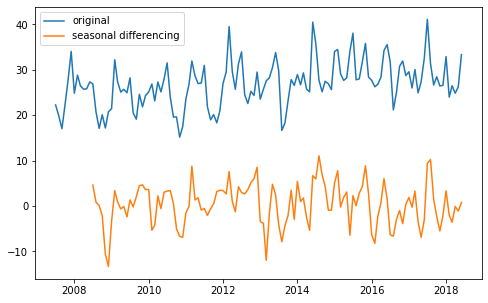

In [43]:
print("Dickey–Fuller test: p=%f" % adfuller(mat_prices_imp["price_concrete"].diff(12).dropna())[1])
print('Dickey-Fuller test ADF Statistic: %f' % adfuller(mat_prices_imp["price_concrete"].diff(12).dropna())[0])
plt.figure(figsize=(8,5))
plt.plot(mat_prices_imp["price_concrete"],label='original')
plt.plot(mat_prices_imp["price_concrete"].diff(12),label='seasonal differencing')
plt.legend(loc='best', fontsize=10)
plt.show()

# Order of differencing

I'll now check auto-correlations to determine if the data needs to be differenced.

### No differencing

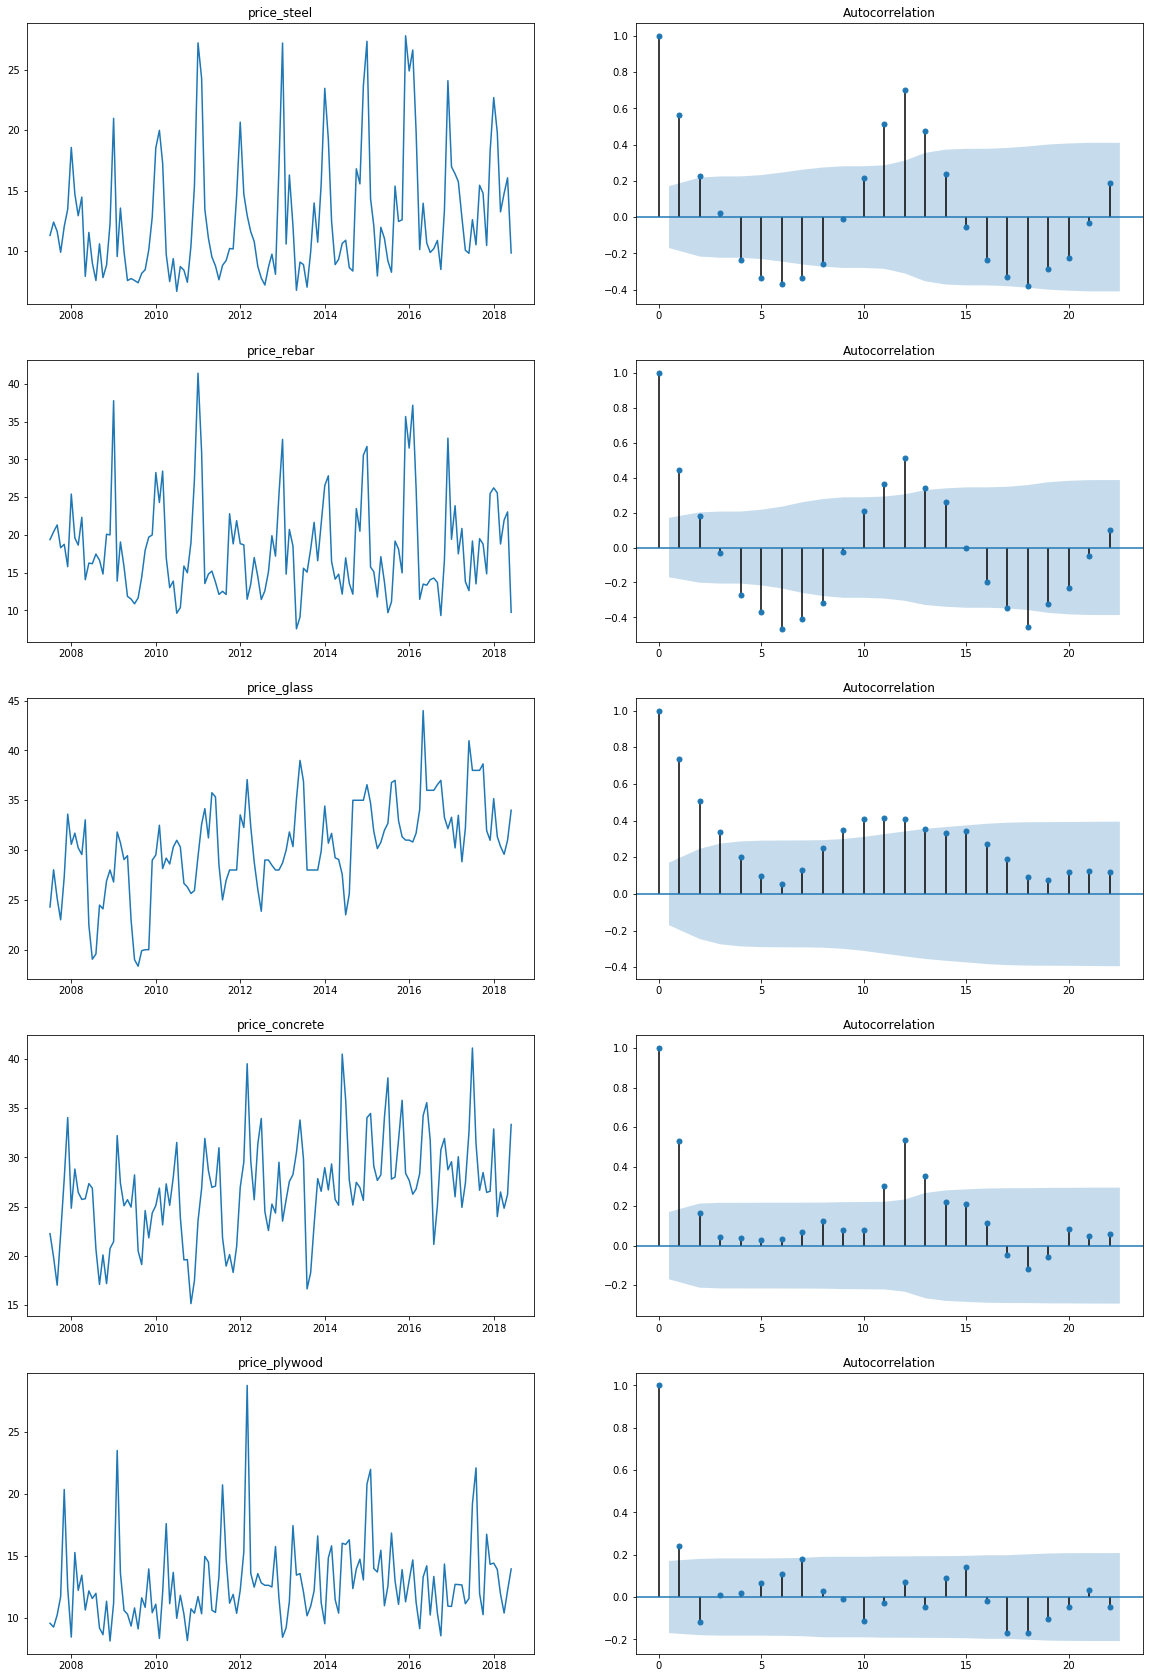

In [45]:
from statsmodels.graphics.tsaplots import plot_acf

fig, axes = plt.subplots(len(mat_prices_imp.columns), 2, sharex=False, figsize=(20,30))

for i, col in enumerate(mat_prices_imp.columns):
    axes[i, 0].plot(mat_prices_imp[col]); axes[i, 0].set_title(col)
    plot_acf(mat_prices_imp[col], ax=axes[i, 1])


### 1st order differencing

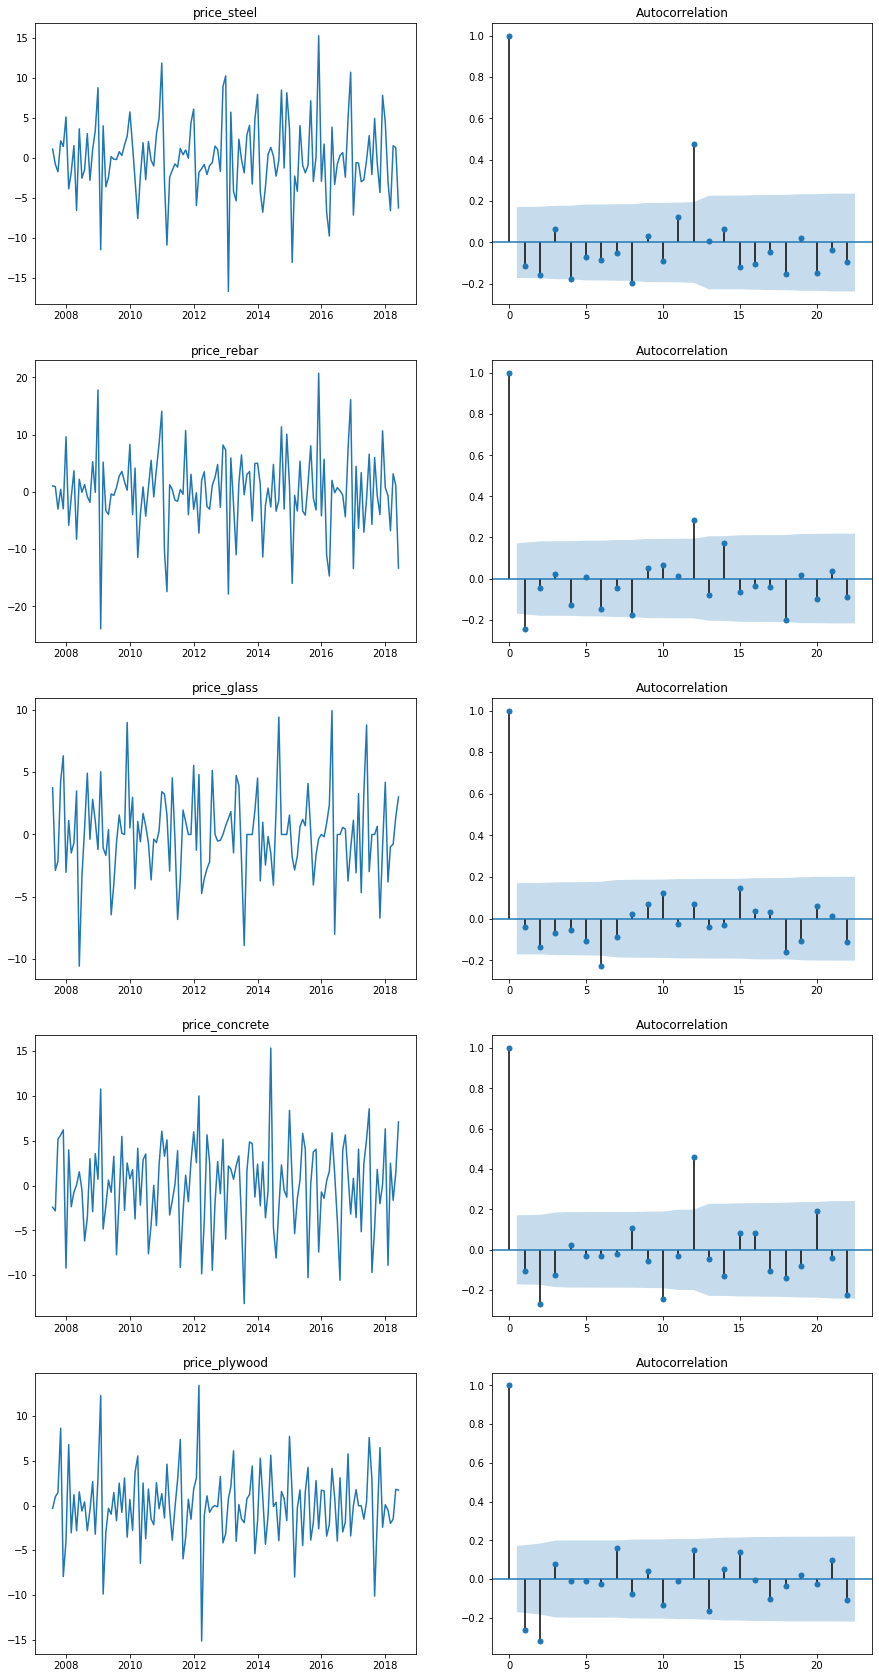

In [46]:
fig, axes = plt.subplots(len(mat_prices_imp.columns), 2, sharex=False, figsize=(15,30))

for i, col in enumerate(mat_prices_imp.columns):
    axes[i, 0].plot(mat_prices_imp[col].diff()); axes[i, 0].set_title(col)
    plot_acf(mat_prices_imp[col].diff().dropna().reset_index(drop=True), ax=axes[i, 1])

### 2nd order differencing

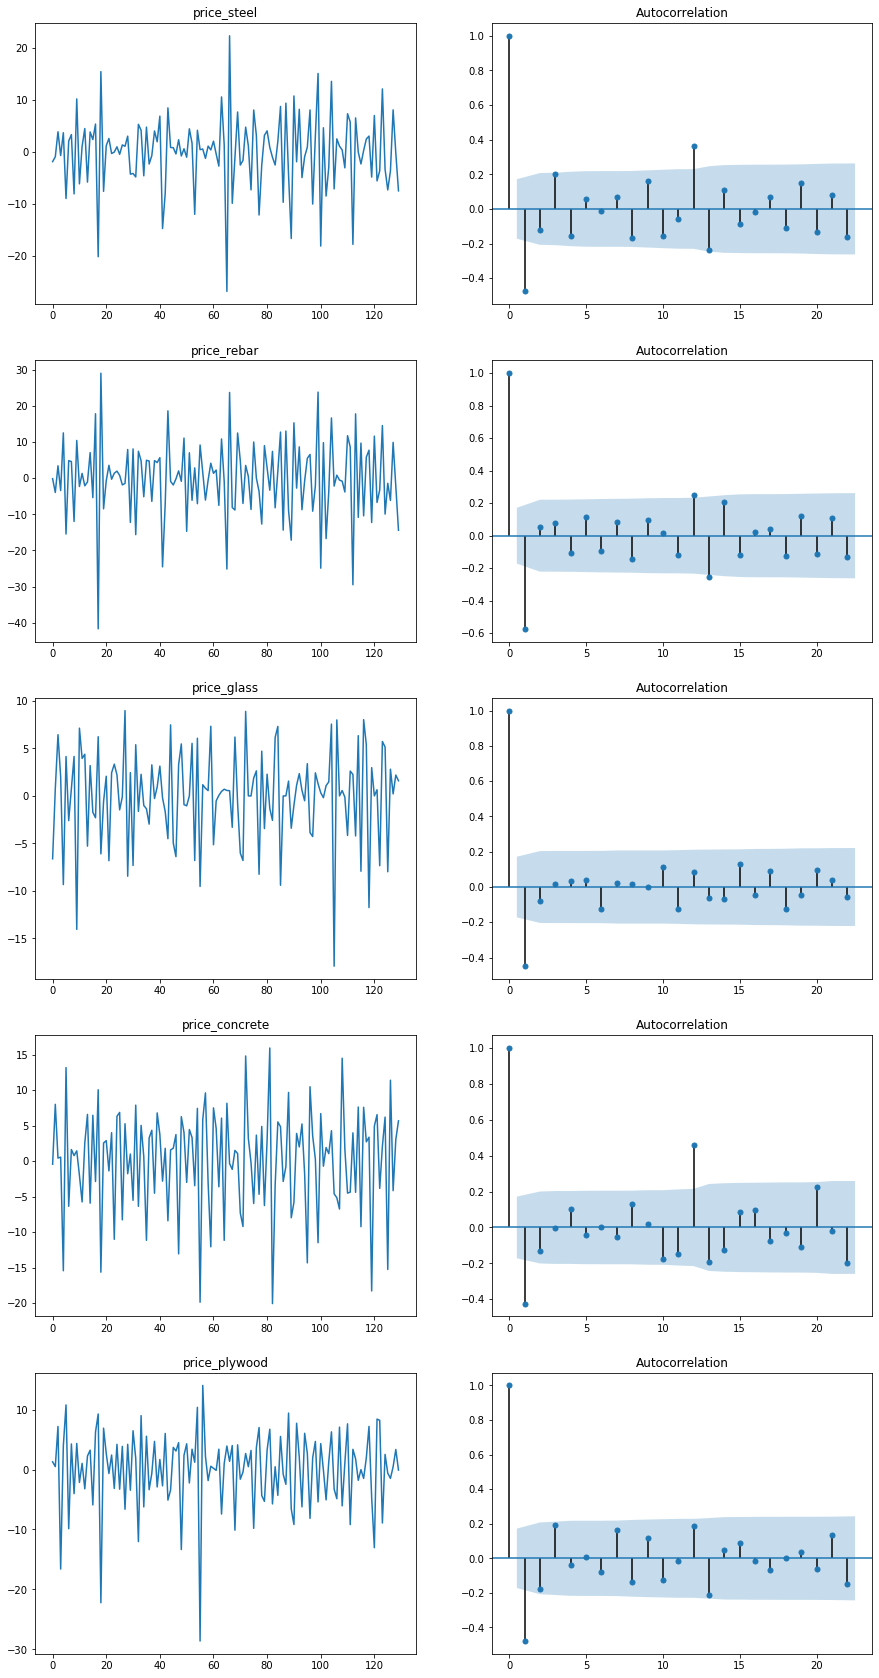

In [47]:
fig, axes = plt.subplots(len(mat_prices_imp.columns), 2, sharex=False, figsize=(15,30))

for i, col in enumerate(mat_prices_imp.columns):
    axes[i, 0].plot(mat_prices_imp[col].diff().diff().dropna().reset_index(drop=True)); axes[i, 0].set_title(col)
    plot_acf(mat_prices_imp[col].diff().diff().dropna().reset_index(drop=True), ax=axes[i, 1])

## Differencing conclusions
The following statement appears to be true for all of the price data:

With no differencing there are strong auto-correlations, and 2nd order differencing introduces a strong negative autocorrelation in the 2nd data point, implying that 1st order differencing is the best choice.

## Order of auto regressive and moving average terms

I'll now look at the partial auto-correlations for the 1st order differenced time series to determine the p hyper paramter for ARIMA.

Based on the ACF plots for the 1st order differenced time series, I will use q=0 (no MA terms).

c:\users\joe\appdata\local\programs\python\python37\lib\site-packages\statsmodels\regression\linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


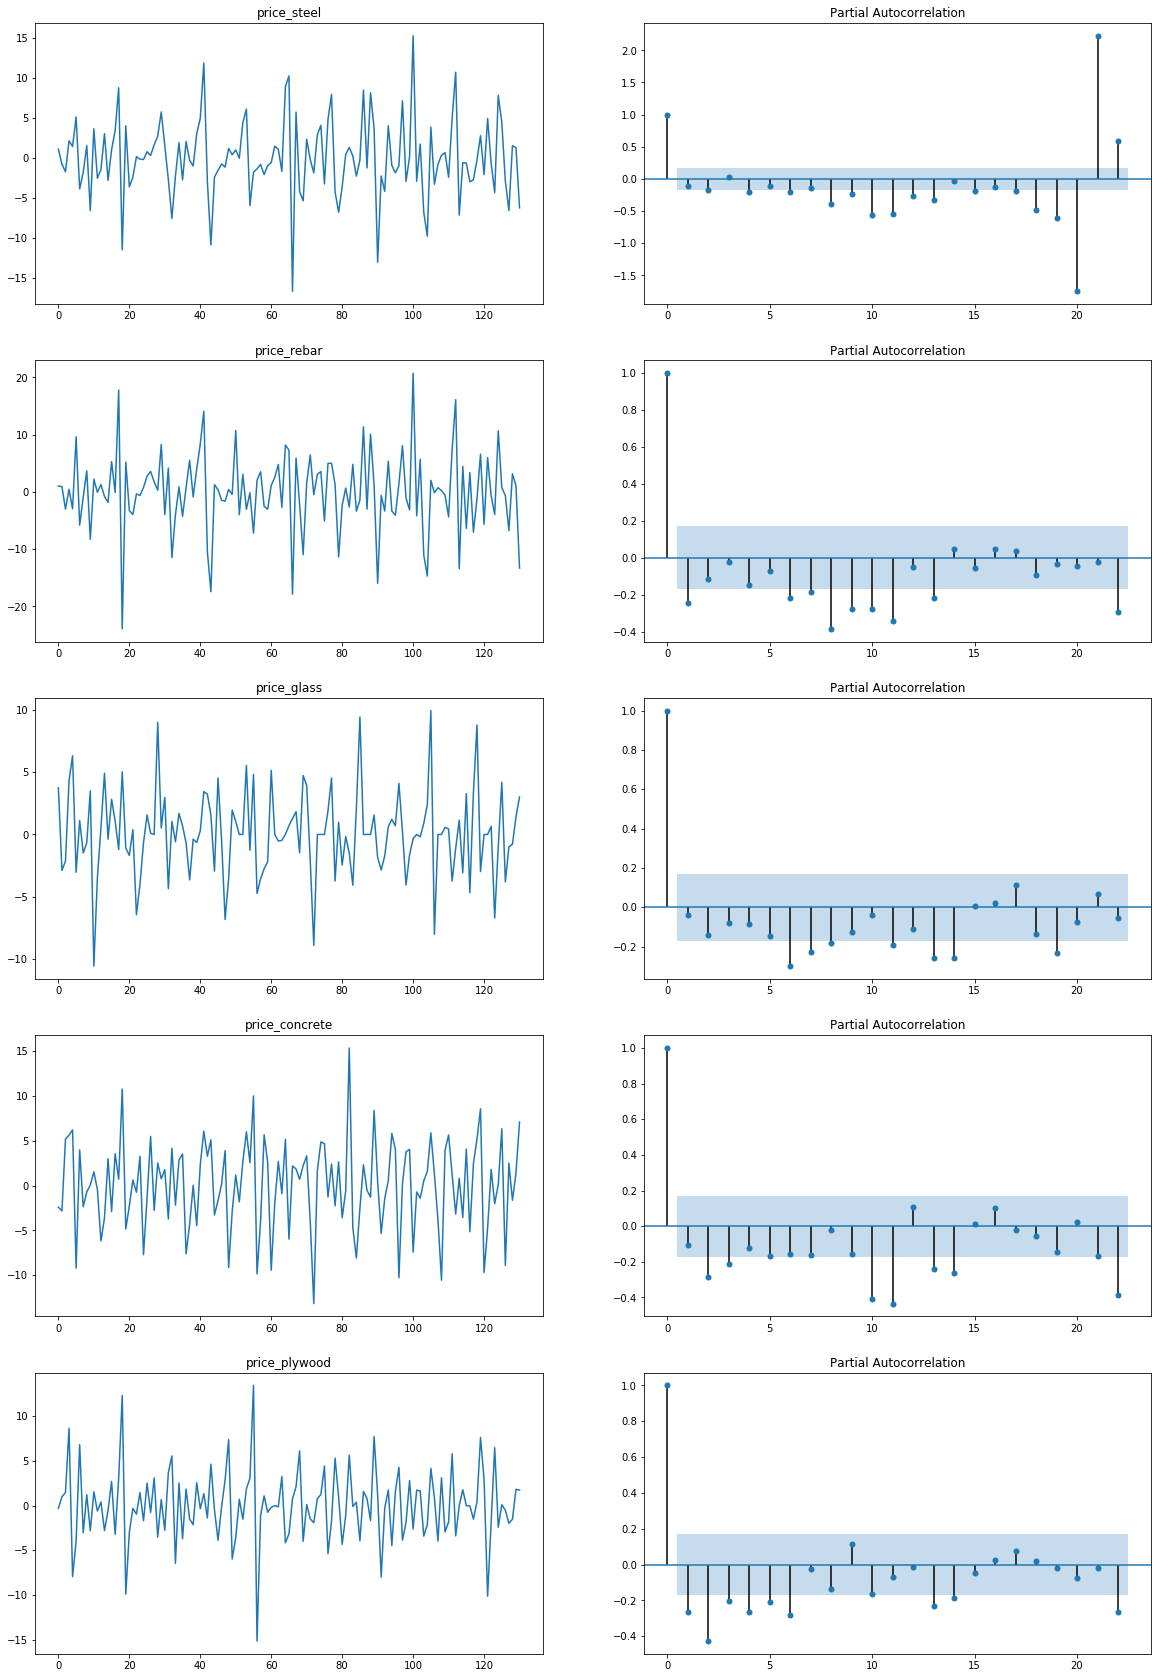

In [48]:
from statsmodels.graphics.tsaplots import plot_pacf

fig, axes = plt.subplots(len(mat_prices_imp.columns), 2, sharex=False, figsize=(20,30))

for i, col in enumerate(mat_prices_imp.columns):
    axes[i, 0].plot(mat_prices_imp[col].diff().dropna().reset_index(drop=True)); axes[i, 0].set_title(col)
    plot_pacf(mat_prices_imp[col].diff().dropna().reset_index(drop=True), ax=axes[i, 1])

Based on the above PACF plots, p=0 should work as well.

## Seasonal decomposition

By looking at the second set of time series plots I produced, the ones where null values were dropped by column, it appears to me that the seasonal frequency of steel, rebar, and concrete is yearly. There are ~11 years of data and around 11 peaks/troughs in each series. Plywood looks like it might have a shorter seasonal frequency, and glass has so much missing data I'm not sure we can even do anything with it! In any case, I'll use statsmodels season_decomposition() to see if my guesses as to the seasonality from eyeballing the plots are correct.

Note: Since the data is (business) daily, the period of a "yearly season" should be 253.

### Steel

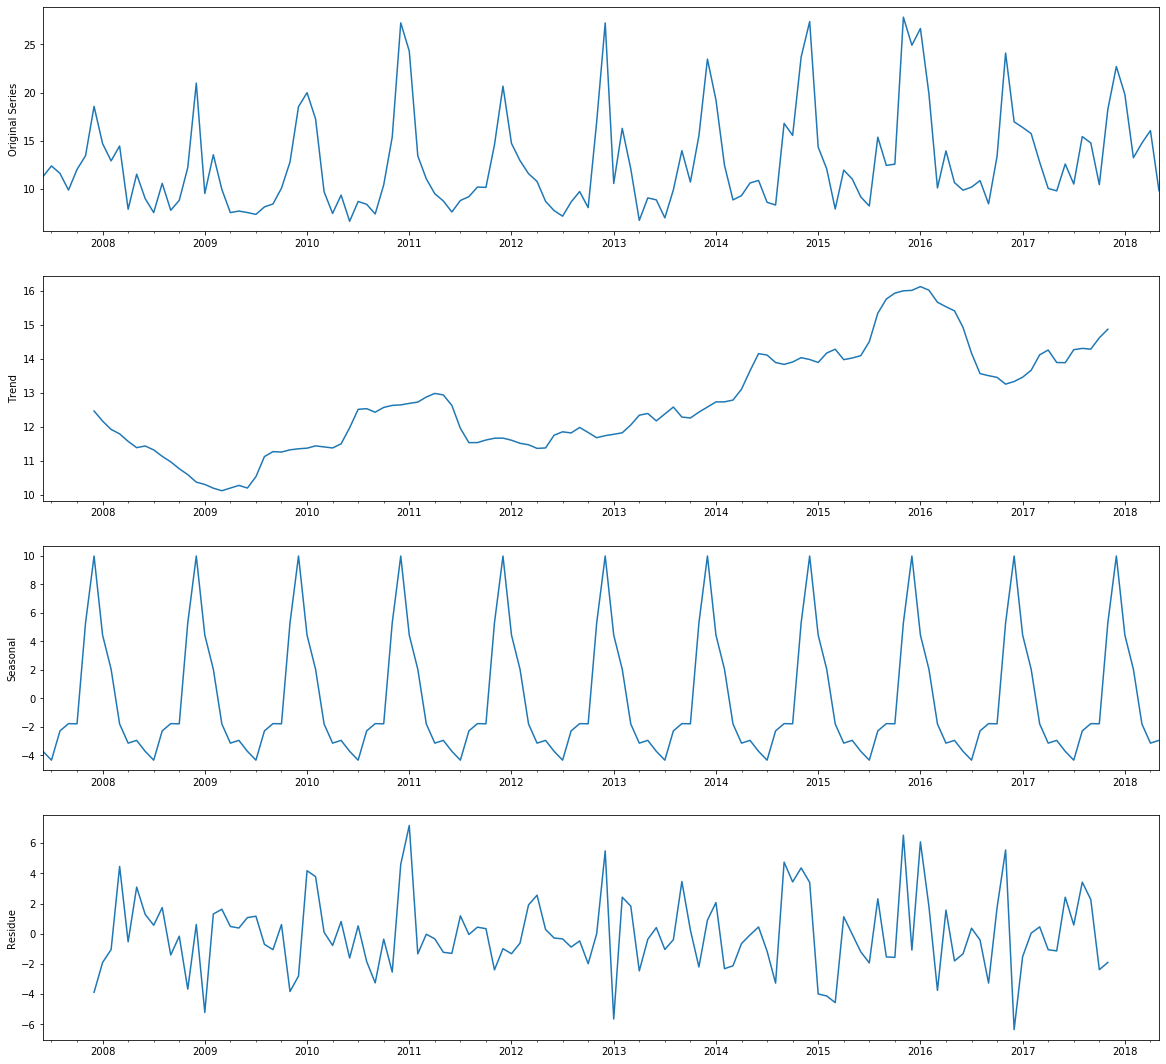

In [54]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(mat_prices_imp.price_steel, model='multiplicative', period=12)

fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(20,19))
result.observed.plot(ax=ax1).set_ylabel('Original Series')
result.trend.plot(ax=ax2).set_ylabel('Trend')
result.seasonal.plot(ax=ax3).set_ylabel('Seasonal')
result.resid.plot(ax=ax4).set_ylabel('Residue')
plt.show()

### Rebar

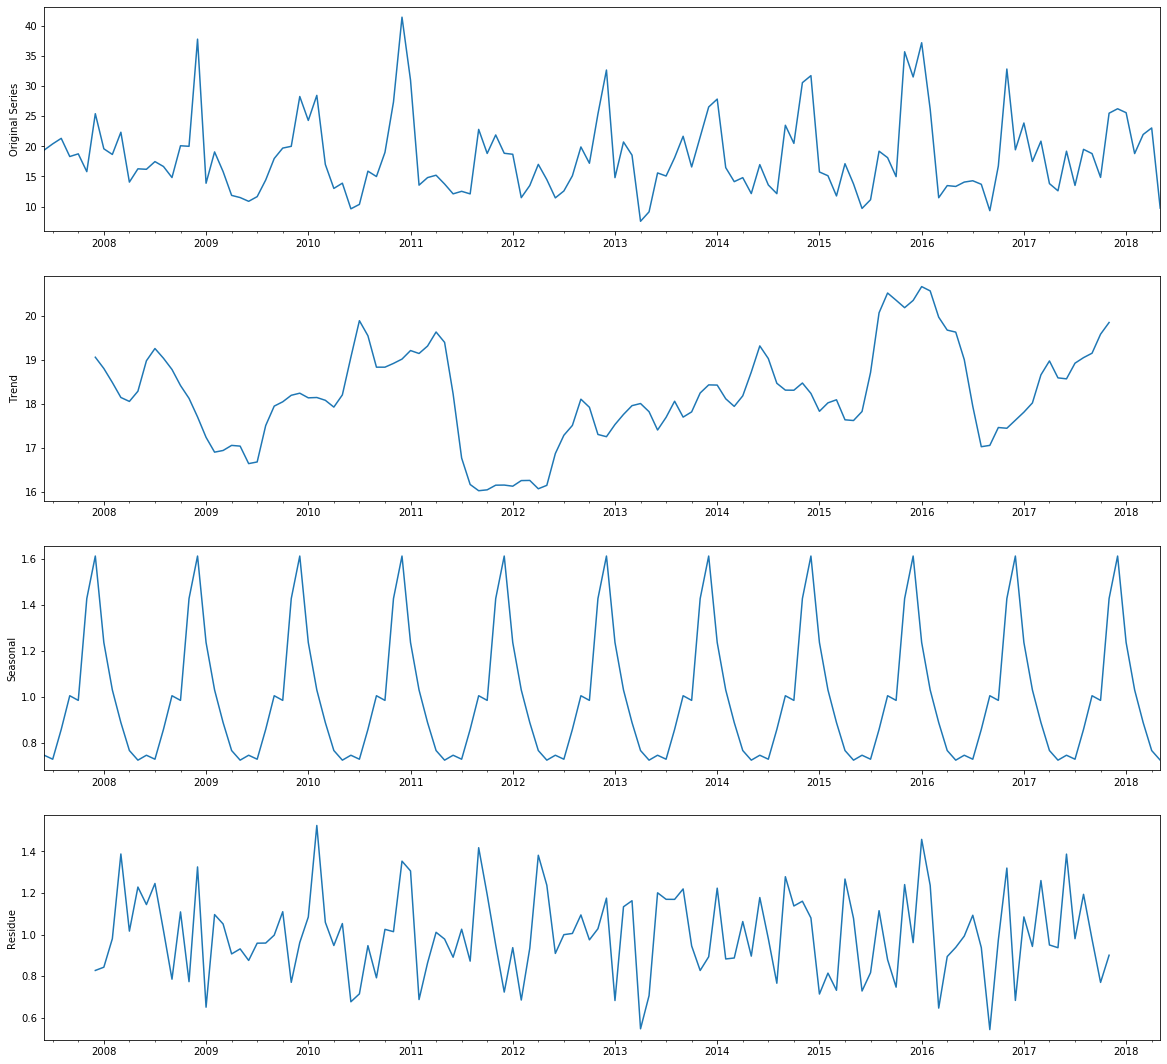

In [55]:
result = seasonal_decompose(mat_prices_imp.price_rebar, model='multiplicative', period=12)

fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(20,19))
result.observed.plot(ax=ax1).set_ylabel('Original Series')
result.trend.plot(ax=ax2).set_ylabel('Trend')
result.seasonal.plot(ax=ax3).set_ylabel('Seasonal')
result.resid.plot(ax=ax4).set_ylabel('Residue')
plt.show()

### Concrete

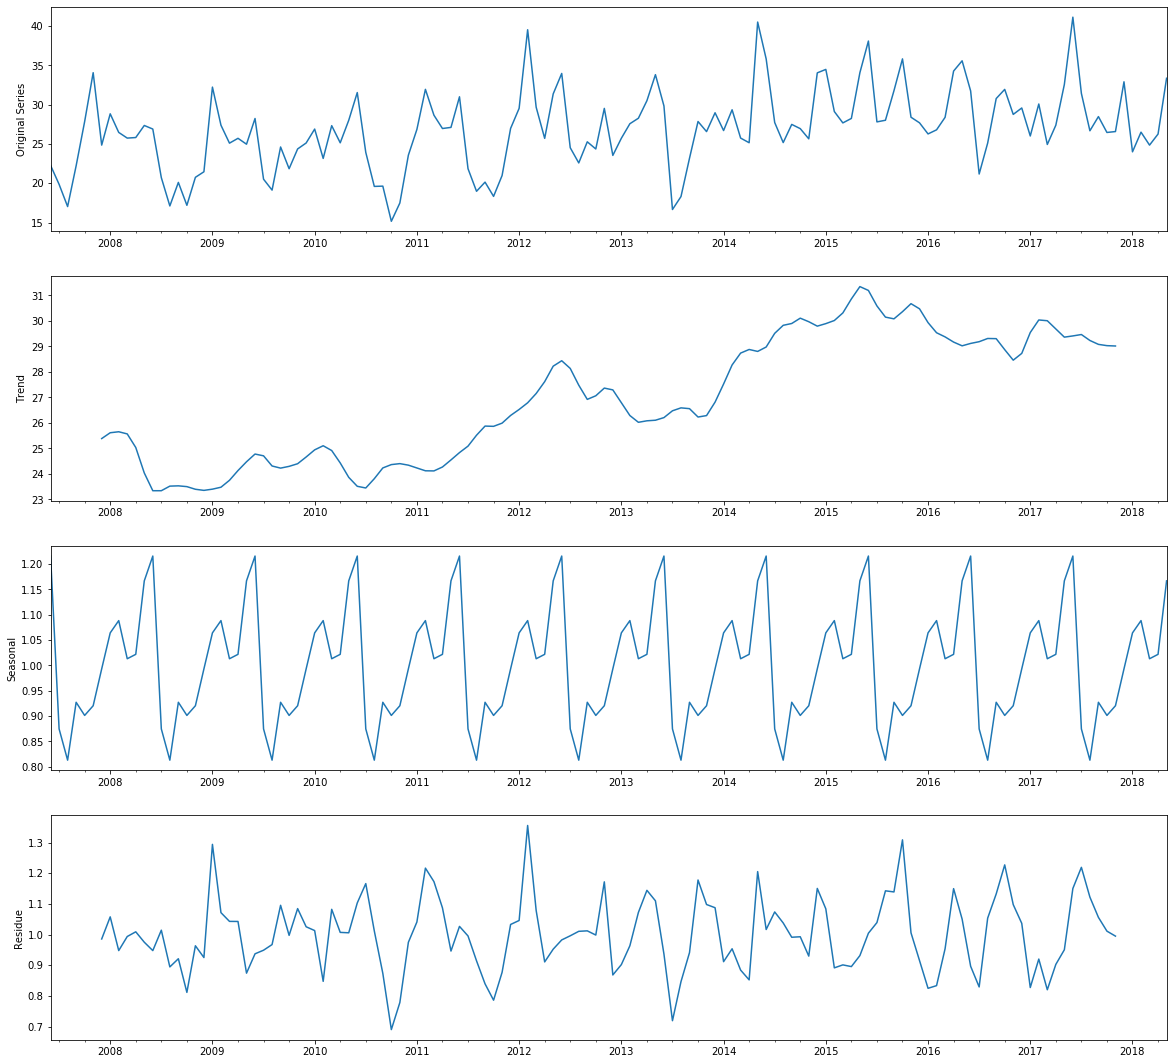

In [57]:
result = seasonal_decompose(mat_prices_imp.price_concrete, model='multiplicative', period=12)

fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(20,19))
result.observed.plot(ax=ax1).set_ylabel('Original Series')
result.trend.plot(ax=ax2).set_ylabel('Trend')
result.seasonal.plot(ax=ax3).set_ylabel('Seasonal')
result.resid.plot(ax=ax4).set_ylabel('Residue')
plt.show()

### Glass

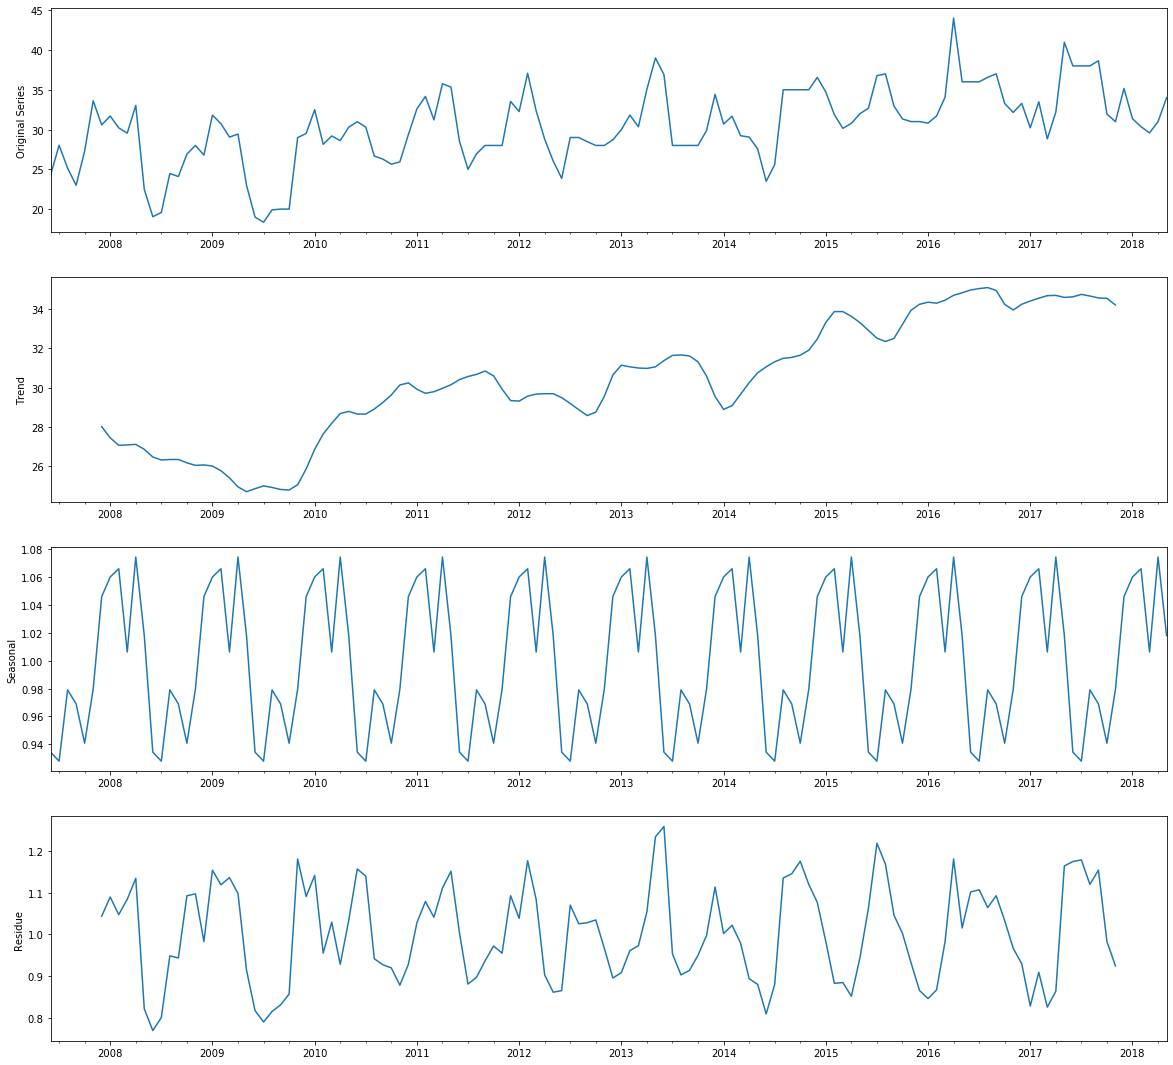

In [58]:
result = seasonal_decompose(mat_prices_imp.price_glass, model='multiplicative', period=12)

fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(20,19))
result.observed.plot(ax=ax1).set_ylabel('Original Series')
result.trend.plot(ax=ax2).set_ylabel('Trend')
result.seasonal.plot(ax=ax3).set_ylabel('Seasonal')
result.resid.plot(ax=ax4).set_ylabel('Residue')
plt.show()

### Plywood

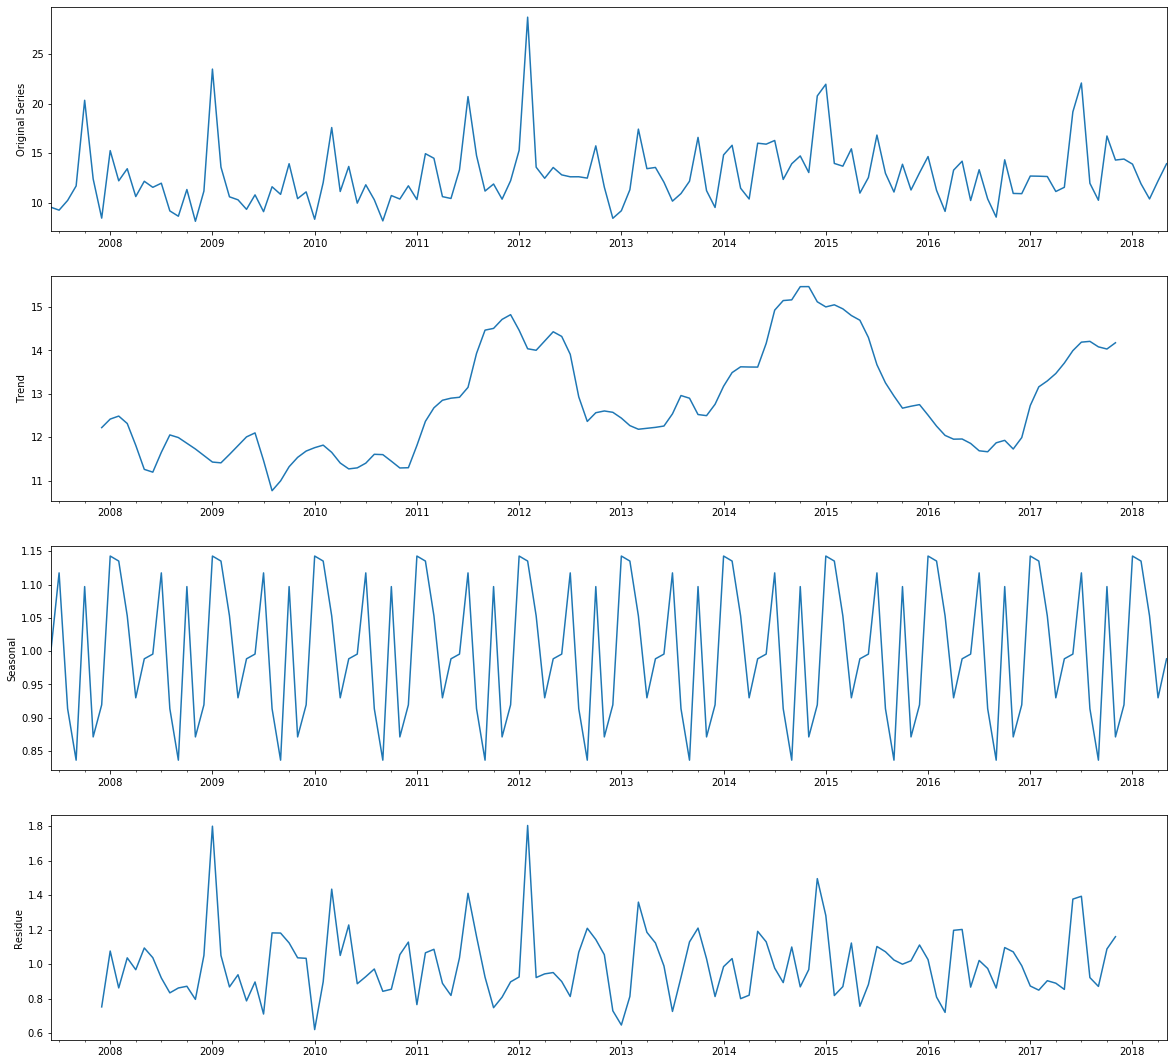

In [59]:
result = seasonal_decompose(mat_prices_imp.price_plywood, model='multiplicative', period=12)

fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(20,19))
result.observed.plot(ax=ax1).set_ylabel('Original Series')
result.trend.plot(ax=ax2).set_ylabel('Trend')
result.seasonal.plot(ax=ax3).set_ylabel('Seasonal')
result.resid.plot(ax=ax4).set_ylabel('Residue')
plt.show()

### Seasonal decomposition discussion

I'm not totally convinced I've properly captured the seasonality for plywood in particular. The rest look OK!

# Seasonal ARIMA models

All the pieces should now be in place to use season ARIMA models to forecast the prices of each construction material. I've been provided with data going back almost 11 years. Training on all that data will be slow and I suspect the model accuracy will not suffer unduly from resampling to monthly values. Since the goal is to forecast up to 6 months in advance, I will start by using the last 6 months of data as a test set to assess the validity of the models. 

The pmdarima package provides auto_arima, which will grid search over the p, d, q hyperparameters to obtain the best fit. Based on the data exploration above, I'll start with the following hyperparamters:

* p=0
* d=1
* q=0
* m=253

And I'll cap p and q at 2.


In [126]:
import pmdarima as pm

models = dict()
for col in mat_prices_imp.columns:
    X_train = mat_prices_imp[col].dropna()[:-24]
    model_auto = pm.auto_arima(X_train,start_p=0, start_q=0,
                               test='adf',# use to determine the d 
                               max_p=1, max_q=1,
                               m=12,              # frequency of series
                               d=None,
                               seasonal=True,
                               start_P=0, 
                               D=None, 
                               trace=True,
                               error_action='ignore',  
                               suppress_warnings=True, 
                               stepwise=True)
    models[col] = model_auto


Performing stepwise search to minimize aic
Fit ARIMA(0,0,0)x(0,0,1,12) [intercept=True]; AIC=625.241, BIC=633.287, Time=0.098 seconds
Fit ARIMA(0,0,0)x(0,0,0,12) [intercept=True]; AIC=667.950, BIC=673.315, Time=0.006 seconds
Fit ARIMA(1,0,0)x(1,0,0,12) [intercept=True]; AIC=582.633, BIC=593.362, Time=0.220 seconds
Fit ARIMA(0,0,1)x(0,0,1,12) [intercept=True]; AIC=606.908, BIC=617.636, Time=0.118 seconds
Fit ARIMA(0,0,0)x(0,0,0,12) [intercept=False]; AIC=872.127, BIC=874.809, Time=0.004 seconds
Fit ARIMA(1,0,0)x(0,0,0,12) [intercept=True]; AIC=627.893, BIC=635.939, Time=0.034 seconds
Fit ARIMA(1,0,0)x(2,0,0,12) [intercept=True]; AIC=576.643, BIC=590.054, Time=0.585 seconds
Fit ARIMA(1,0,0)x(2,0,1,12) [intercept=True]; AIC=580.988, BIC=597.081, Time=1.220 seconds
Fit ARIMA(1,0,0)x(1,0,1,12) [intercept=True]; AIC=574.322, BIC=587.733, Time=0.331 seconds
Fit ARIMA(1,0,0)x(0,0,1,12) [intercept=True]; AIC=604.602, BIC=615.330, Time=0.175 seconds
Fit ARIMA(1,0,0)x(1,0,2,12) [intercept=True]; 

## Model diagnostics

Plot the model diagnostics.

### Steel

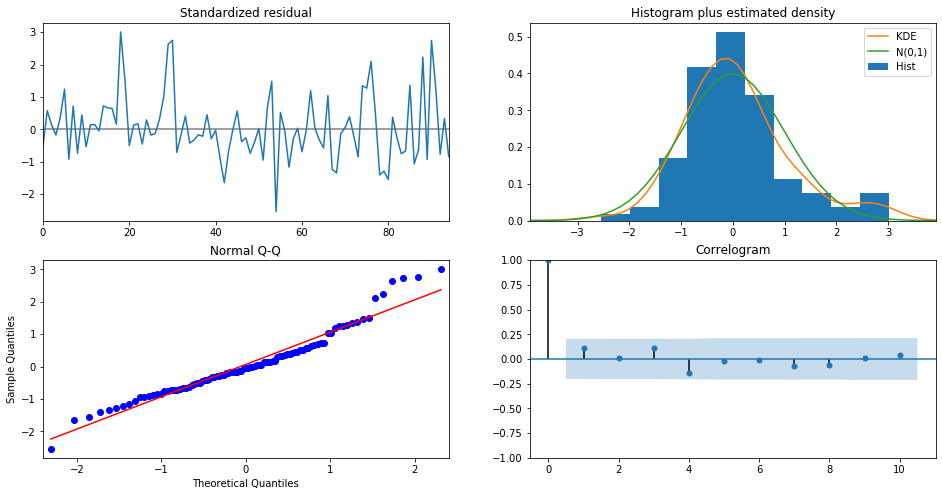

In [87]:
diag = models["price_steel"].plot_diagnostics(figsize=(16,8))

### Rebar

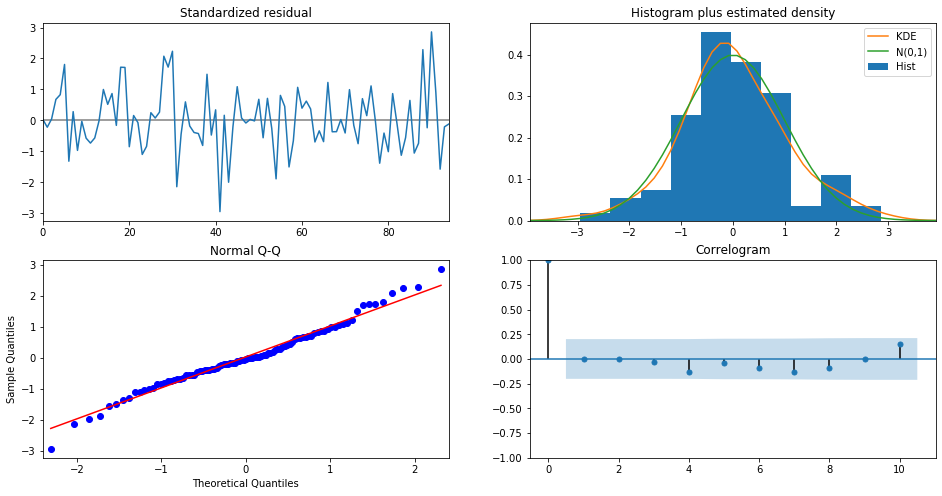

In [90]:
diag = models["price_rebar"].plot_diagnostics(figsize=(16,8))

### Concrete

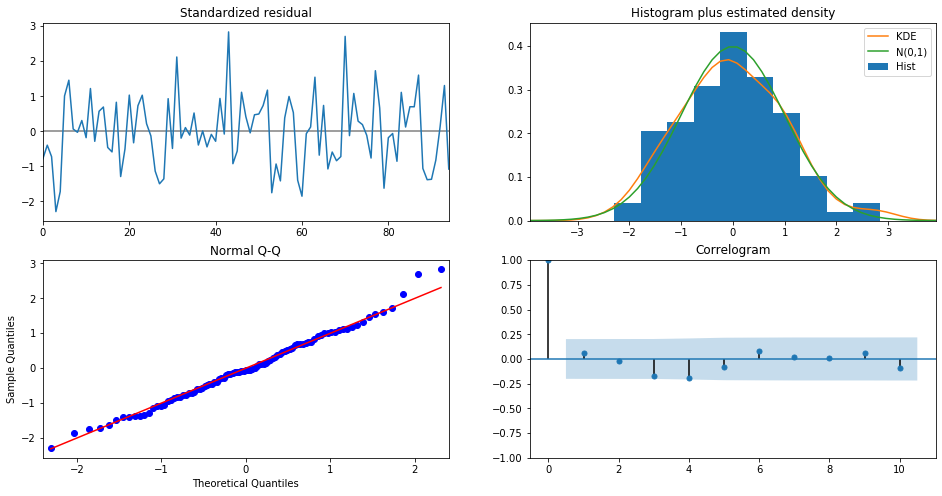

In [91]:
diag = models["price_concrete"].plot_diagnostics(figsize=(16,8))

### Glass

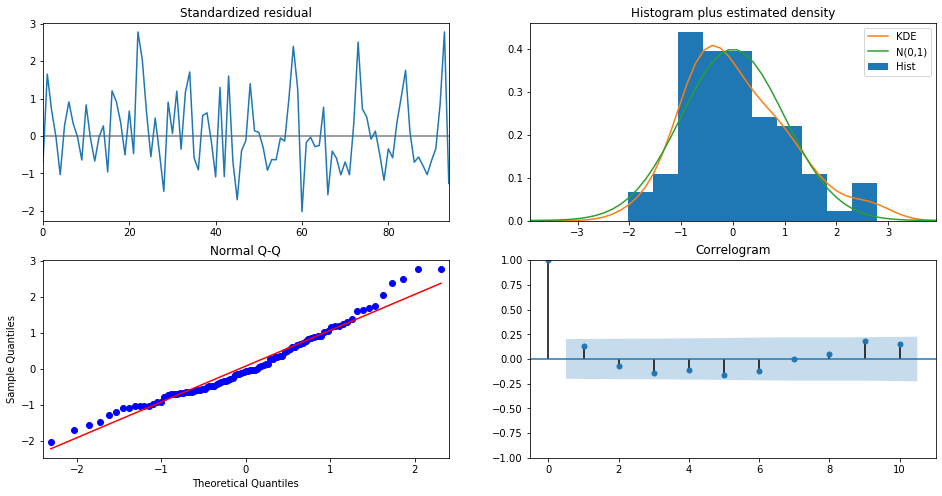

In [92]:
diag = models["price_glass"].plot_diagnostics(figsize=(16,8))

### Plywood

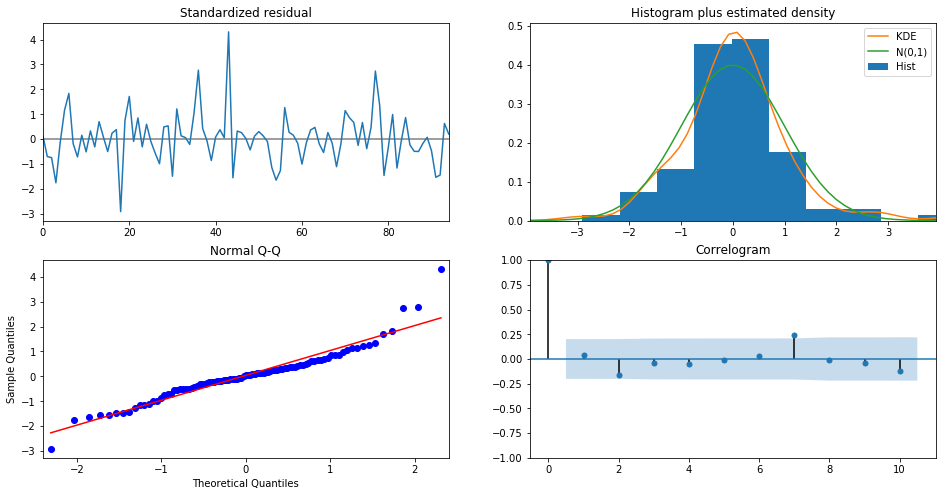

In [93]:
diag = models["price_plywood"].plot_diagnostics(figsize=(16,8))

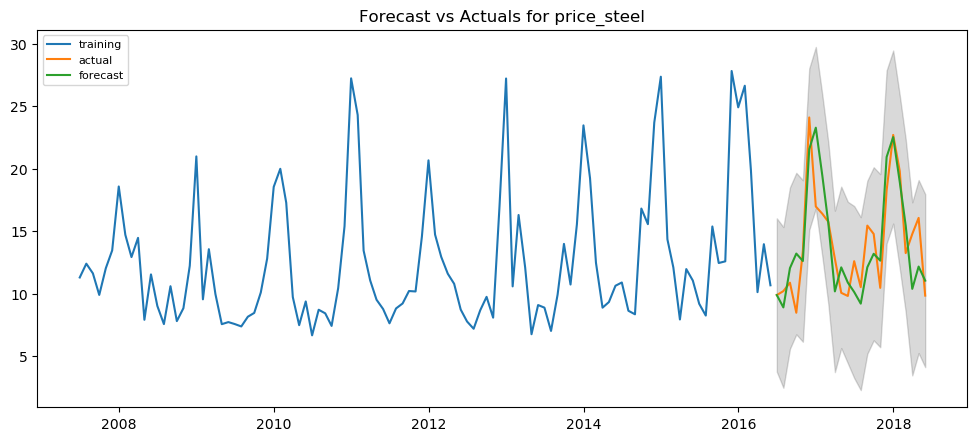

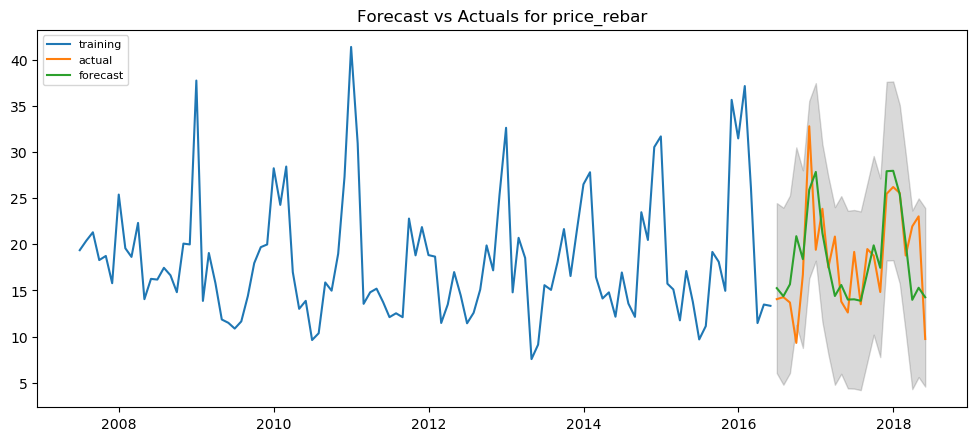

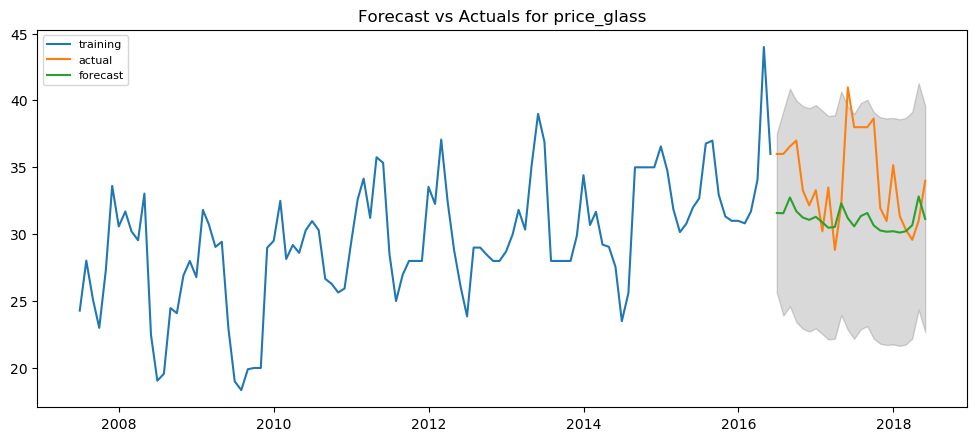

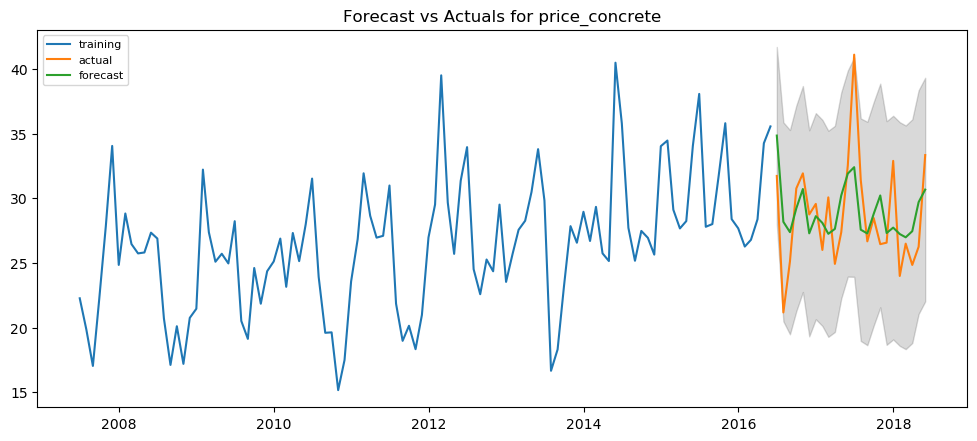

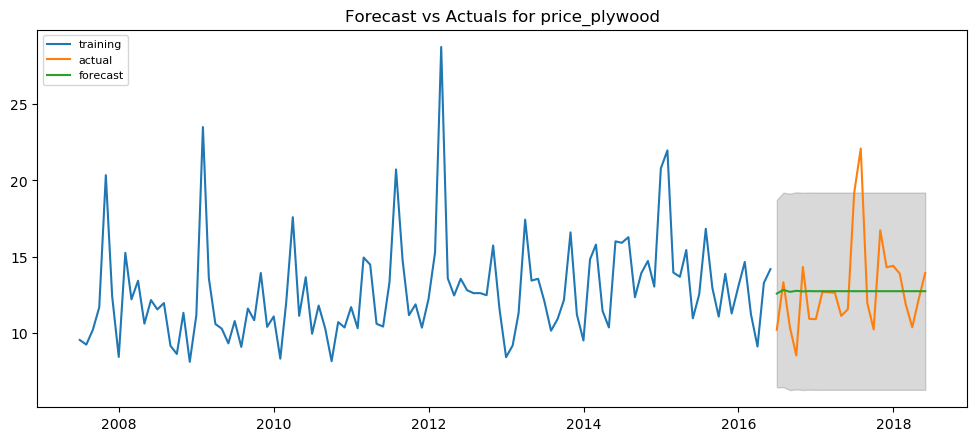

In [127]:
for col in models.keys():
    X_train = mat_prices_imp[col].dropna()[:-24]
    X_test = mat_prices_imp[col].dropna()[-24:]
    fc, conf = models[col].predict(n_periods=24, return_conf_int=True, alpha=0.05)  # 95% conf
    # Make as pandas series
    fc_series    = pd.Series(fc, index=X_test.index)
    lower_series = pd.Series(conf[:, 0], index=X_test.index)
    upper_series = pd.Series(conf[:, 1], index=X_test.index)
    # Plot
    plt.figure(figsize=(12,5), dpi=100)
    plt.plot(X_train, label='training')
    plt.plot(X_test, label='actual')
    plt.plot(fc_series, label='forecast')
    plt.fill_between(lower_series.index, lower_series, upper_series, 
                     color='k', alpha=.15)
    plt.title('Forecast vs Actuals for {}'.format(col))
    plt.legend(loc='upper left', fontsize=8)
    plt.show()

### Testing on the last 6 months of data -- discussion

The model for the steel price is fairly accurate, not surprisingly since this was the time series with the clearest yearly seasonality. The other models have trouble capturing the season fluctuations, the re-sampling may be the culprit and we might achieve better performance by avoiding the resampling and simply being patient. For the price of glass, however, I think it might be necessary to other collect better data (with fewer missing values) or spend more time on properly imputing the missing data.

# Price prediction 6 months out

I will now retrain the models on the entire dataset, and then use them to predict the prices 6 months from now!

In [128]:
import pmdarima as pm

models = dict()
for col in mat_prices_imp.columns:
    X_train = mat_prices_imp[col]
    model_auto = pm.auto_arima(X_train,start_p=0, start_q=0,
                               test='adf',# use to determine the d 
                               max_p=2, max_q=2,
                               m=12,              # frequency of series
                               d=None,           # let model determine 'd'
                               seasonal=True,   # No Seasonality
                               start_P=0, 
                               D=None, 
                               trace=True,
                               error_action='ignore',  
                               suppress_warnings=True, 
                               stepwise=True)
    models[col] = model_auto

Performing stepwise search to minimize aic
Fit ARIMA(0,0,0)x(0,0,1,12) [intercept=True]; AIC=759.761, BIC=768.410, Time=0.097 seconds
Fit ARIMA(0,0,0)x(0,0,0,12) [intercept=True]; AIC=807.719, BIC=813.484, Time=0.006 seconds
Fit ARIMA(1,0,0)x(1,0,0,12) [intercept=True]; AIC=706.902, BIC=718.433, Time=0.239 seconds
Fit ARIMA(0,0,1)x(0,0,1,12) [intercept=True]; AIC=732.060, BIC=743.591, Time=0.136 seconds
Fit ARIMA(0,0,0)x(0,0,0,12) [intercept=False]; AIC=1069.259, BIC=1072.142, Time=0.005 seconds
Fit ARIMA(1,0,0)x(0,0,0,12) [intercept=True]; AIC=760.133, BIC=768.781, Time=0.037 seconds
Fit ARIMA(1,0,0)x(2,0,0,12) [intercept=True]; AIC=697.715, BIC=712.129, Time=0.670 seconds
Fit ARIMA(1,0,0)x(2,0,1,12) [intercept=True]; AIC=695.837, BIC=713.134, Time=1.691 seconds
Fit ARIMA(1,0,0)x(1,0,1,12) [intercept=True]; AIC=693.838, BIC=708.252, Time=0.384 seconds
Fit ARIMA(1,0,0)x(0,0,1,12) [intercept=True]; AIC=732.384, BIC=743.915, Time=0.166 seconds
Fit ARIMA(1,0,0)x(1,0,2,12) [intercept=True]

Fit ARIMA(1,0,0)x(2,0,1,12) [intercept=True]; AIC=721.766, BIC=739.062, Time=1.865 seconds
Fit ARIMA(1,0,0)x(1,0,1,12) [intercept=True]; AIC=717.795, BIC=732.209, Time=0.541 seconds
Fit ARIMA(1,0,0)x(0,0,1,12) [intercept=True]; AIC=736.909, BIC=748.440, Time=0.206 seconds
Fit ARIMA(1,0,0)x(1,0,2,12) [intercept=True]; AIC=719.741, BIC=737.038, Time=1.760 seconds
Fit ARIMA(1,0,0)x(0,0,2,12) [intercept=True]; AIC=731.813, BIC=746.227, Time=0.649 seconds
Fit ARIMA(1,0,0)x(2,0,2,12) [intercept=True]; AIC=721.786, BIC=741.965, Time=2.035 seconds
Near non-invertible roots for order (1, 0, 0)(2, 0, 2, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(0,0,0)x(1,0,1,12) [intercept=True]; AIC=750.795, BIC=762.326, Time=0.545 seconds
Fit ARIMA(2,0,0)x(1,0,1,12) [intercept=True]; AIC=715.740, BIC=733.037, Time=0.729 seconds
Fit ARIMA(2,0,0)x(0,0,1,12) [intercept=True]; AIC=734.103, BIC=748.517, Time=0.332 seconds
Fit ARIMA(2,0,0)x(1,0,

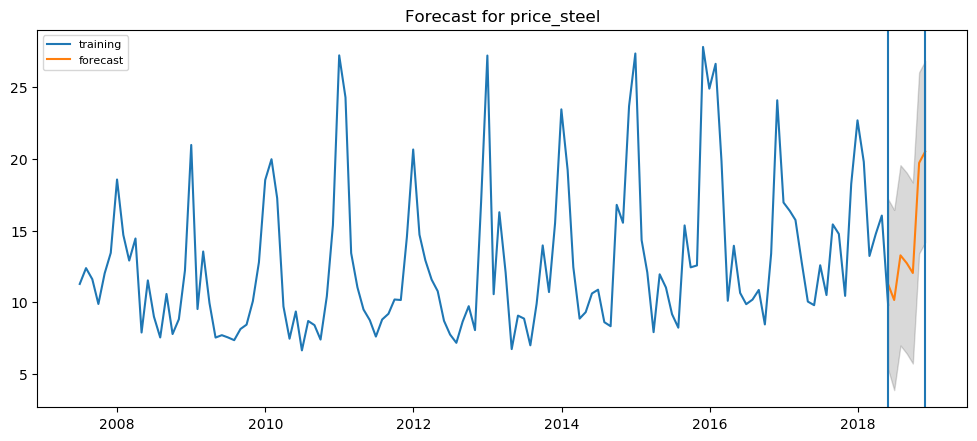

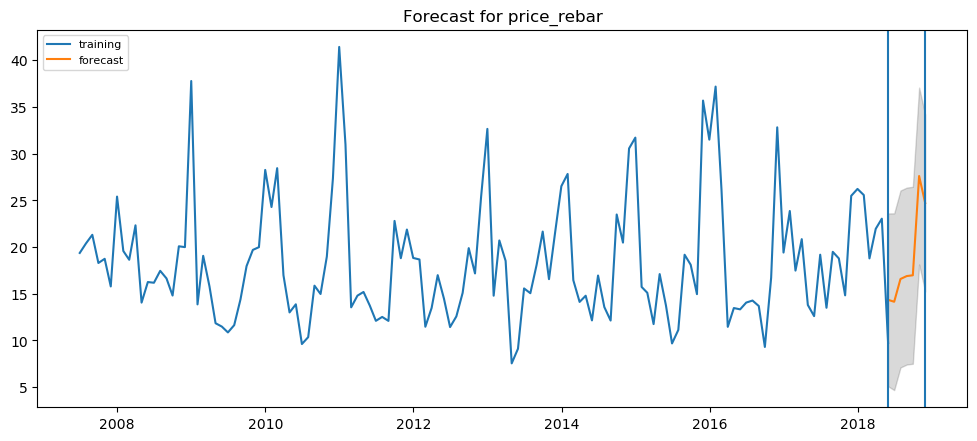

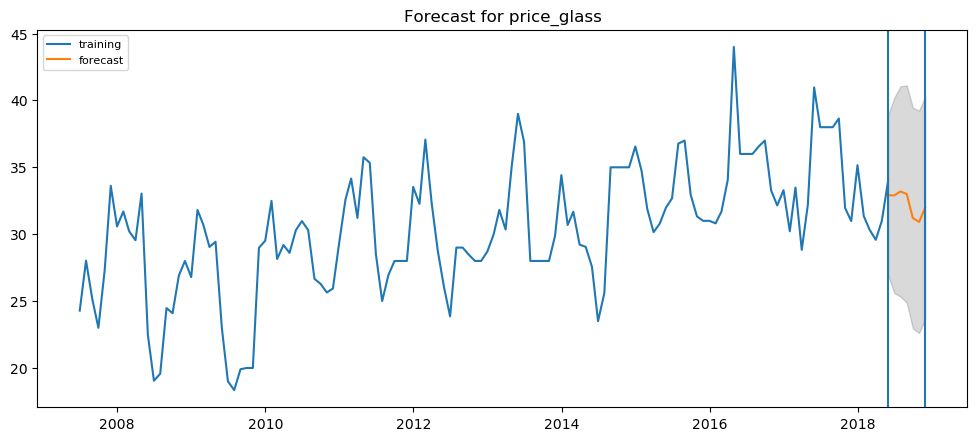

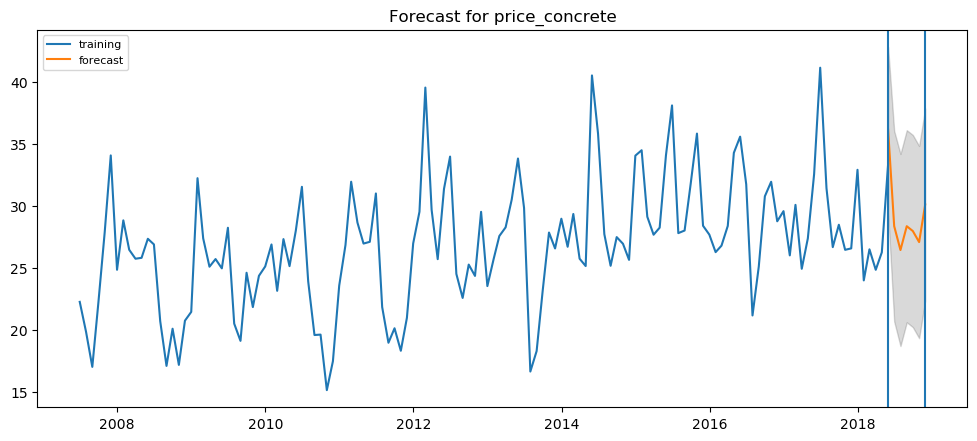

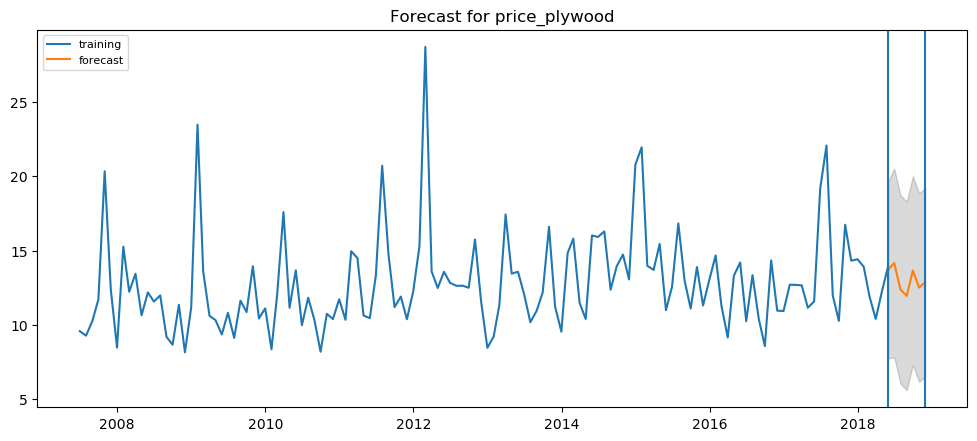

In [150]:
for col in models.keys():
    X_train = mat_prices_imp[col].dropna()
    fc, conf = models[col].predict(n_periods=7, return_conf_int=True, alpha=0.05)  # 95% conf
    # Make as pandas series
    fc_series    = pd.Series(fc, index=pd.date_range(mat_prices_imp.index[-1], periods=7, freq='M'))
    lower_series = pd.Series(conf[:, 0], index=pd.date_range(mat_prices_imp.index[-1], periods=7, freq='M'))
    upper_series = pd.Series(conf[:, 1], index=pd.date_range(mat_prices_imp.index[-1], periods=7, freq='M'))
    # Plot
    plt.figure(figsize=(12,5), dpi=100)
    plt.plot(X_train, label='training')
    plt.plot(fc_series, label='forecast')
    plt.fill_between(lower_series.index, lower_series, upper_series, 
                     color='k', alpha=.15)
    plt.title('Forecast for {}'.format(col))
    plt.legend(loc='upper left', fontsize=8)
    plt.axvline(x=pd.to_datetime(mat_prices_imp.index[-1]))
    plt.axvline(x=pd.date_range(mat_prices_imp.index[-1], periods=7, freq='M')[-1])
    plt.show()

# Purchasing advice

Based on the forecasts above, I would give the following purchasing advice:

* Steel: Buy now, the price will be higher in 6 months
* Rebar: Buy now, the price will be higher in 6 months
* Glass: The price may be lower in 6 months but the CI is quite large for glass. Wait to purchase but keep an eye on trends.
* Concrete: The price will be lower in 6 months, wait to purchase.